# The IMDb Dataset
The IMDb dataset consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [19]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [20]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import math
import numpy as np
import os
import time
from datetime import timedelta
import shutil
from datetime import datetime

# new
import re
from keras.models import Sequential, load_model

## Check configuration

In [21]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.1.0-rc2-17-ge5bf8de 2.1.0


In [22]:
print(tf.keras.__version__)

2.2.4-tf


In [23]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [24]:
# note: these need to be specified in the config.sh file
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    checkpoint_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [25]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm

In [26]:
import importlib
importlib.reload(pp);
importlib.reload(mm);

## Define Parameters

In [27]:
TOKENIZER = 'bert-base-multilingual-uncased'
SEQUENCE_LENGTH = 512

## Loading a data from Tensorflow Datasets

In [28]:
#data, info = tensorflow_datasets.load(name='glue/sst2',
#                                      data_dir=data_dir,
#                                      with_info=True)

data, info = tensorflow_datasets.load(name="imdb_reviews",
                            data_dir=data_dir,
                            as_supervised=True,
                            with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/vera_luechinger/data/imdb_reviews/plain_text/1.0.0


In [29]:
# IMDb specific:
data_valid = data['test'].take(1000)

# trying to create a true validation data set for after the computation
#data_valid_ext = data['test'].take(2000)
#data_valid = data_valid_ext.take(1000)

### Checking basic info from the metadata

In [30]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [31]:
pp.print_info_dataset(info)

Labels:
      ['neg', 'pos']

Number of label:
      2

Structure of the data:
      dict_keys(['text', 'label'])

Number of entries:
   Train dataset: 25000
   Test dataset:  25000
--> validation dataset not defined


### Checking basic info from the metadata

In [32]:
data

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [33]:
data.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [34]:
# only works for glue-compatible datasets
try:
    pp.print_info_data(data['train'])
except AttributeError:
    print('data format incompatible')


# Structure of the data:

   <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>

# Output shape of one entry:
   (TensorShape([]), TensorShape([]))

# Output types of one entry:
   (tf.string, tf.int64)

# Output typesof one entry:
   (<class 'tensorflow.python.framework.ops.Tensor'>, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (25000, 2)
data format incompatible


## Define parameters of the model

In [35]:
# changes: had to eliminate all lines concerning a test data set because we only have train and valid


# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2

# extract parameters
size_train_dataset = info.splits['train'].num_examples
#size_test_dataset = info.splits['test'].num_examples
#size_valid_dataset = info.splits['validation'].num_examples

# the size for the validation data set has been manually computed according to the function 
# pp.print_info_data because the test set has been manually split above
size_valid_dataset = np.shape(np.array(list(data_valid.as_numpy_iterator())))[0]
number_label = info.features["label"].num_classes

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
#STEP_EPOCH_TEST = math.ceil(size_test_dataset/BATCH_SIZE_TEST)
STEP_EPOCH_VALID = math.ceil(size_valid_dataset/BATCH_SIZE_VALID)


#print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))
#print('Batch size:            {:6}/{:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, BATCH_SIZE_VALID))
#print('Step per epoch:        {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_TEST, STEP_EPOCH_VALID))
#print('Total number of batch: {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_TEST*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))
print('Dataset size:          {:6}/{:6}'.format(size_train_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           25000/  1000
Batch size:                32/    64
Step per epoch:           782/    16
Total number of batch:   2346/    48


## Tokenizer and prepare data for BERT

In [36]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(TOKENIZER)

In [37]:
# recap of input dataset
print(data['train'])
print(tf.data.experimental.cardinality(data['train']))
#print(tf.data.experimental.cardinality(data['test']))
#print(tf.data.experimental.cardinality(data['validation']))
print(tf.data.experimental.cardinality(data_valid))
# super slow since looping over all data
#print(len(list(data['train'])))

<DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)


### Additional steps for the IMDb dataset specifically

#### Cleaning

In [38]:
def preprocess_reviews(reviews):
    #REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    
    #ae, oe, ue => only for GERMAN data
    #REPLACE_UMLAUT_AE = re.compile("(ae)")
    #REPLACE_UMLAUT_OE = re.compile("(oe)")
    #REPLACE_UMLAUT_UE = re.compile("(ue)")
    
    #reviews = [REPLACE_NO_SPACE.sub("", line[0].decode("utf-8").lower()) for line in np.array(list(reviews.as_numpy_iterator()))]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line[0].decode("utf-8")) for line in np.array(list(reviews.as_numpy_iterator()))]# for line in reviews]
    #reviews = [REPLACE_UMLAUT_AE.sub("ä", line[0]) for line in reviews]
    #reviews = [REPLACE_UMLAUT_OE.sub("ö", line[0]) for line in reviews]
    #reviews = [REPLACE_UMLAUT_UE.sub("ü", line[0]) for line in reviews]
    
    return reviews

In [39]:
reviews_train_clean = preprocess_reviews(data['train'])
reviews_valid_clean = preprocess_reviews(data_valid)

#### Converting Data to GLUE Format

In [40]:
labels_train = [int(line[1].decode("utf-8")) for line in np.array(list(data['train'].as_numpy_iterator()))]
labels_valid = [int(line[1].decode("utf-8")) for line in np.array(list(data_valid.as_numpy_iterator()))]

In [41]:
train_data_np = pp.convert_np_array_to_glue_format(reviews_train_clean, labels_train)
valid_data_np = pp.convert_np_array_to_glue_format(reviews_valid_clean, labels_valid, shift=len(list(train_data_np)))

In [42]:
# Prepare data for BERT
#train_dataset = glue_convert_examples_to_features(data['train'], 
#                                                  tokenizer, 
#                                                  max_length=128, 
#                                                  task='sst-2')
#test_dataset = glue_convert_examples_to_features(data['test'], 
#                                                  tokenizer, 
#                                                  max_length=128, 
#                                                  task='sst-2')
#valid_dataset = glue_convert_examples_to_features(data['validation'], 
#                                                  tokenizer, 
#                                                  max_length=128, 
#                                                  task='sst-2')

train_dataset = glue_convert_examples_to_features(train_data_np, 
                                                  tokenizer, 
                                                  max_length=SEQUENCE_LENGTH, 
                                                  task='sst-2')
valid_dataset = glue_convert_examples_to_features(valid_data_np, 
                                                  tokenizer, 
                                                  max_length=SEQUENCE_LENGTH, 
                                                  task='sst-2')

In [43]:
# recap of pre processing dataset
print(train_dataset)
print(tf.data.experimental.cardinality(train_dataset))
#print(tf.data.experimental.cardinality(test_dataset))
print(tf.data.experimental.cardinality(valid_dataset))
# super slow since looping over all data
print(len(list(train_dataset)))

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
25000


In [44]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
#test_dataset = test_dataset.shuffle(100).batch(BATCH_SIZE_TEST).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

In [45]:
pp.print_info_data(valid_dataset)

# Structure of the data:

   <BatchDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (16, 2)
   ---> 16 batches
   ---> 2 dim
        label
           shape: (64,)
        dict structure
           dim: 3
           [i

## Check the final data

In [46]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (2346, 2)
   ---> 2346 batches
   ---> 2 dim
        label
           shape: (32,)
        dict structure
           dim: 3
        

In [47]:
pp.print_detail_tokeniser(train_dataset, tokenizer, max_entries=40)

 input_ids     ---->    attention_mask    token_type_ids    modified text                 

       101     ---->           1                 1          [ C L S ]                     
       107     ---->           1                 1          "                             
     10103     ---->           1                 1          t h e                         
     42592     ---->           1                 1          p l a i n s                   
     10629     ---->           1                 1          # # m a n                     
       107     ---->           1                 1          "                             
     36076     ---->           1                 1          r e p r e s e n t s           
     10103     ---->           1                 1          t h e                         
     11866     ---->           1                 1          d i r e c t o r               
     17333     ---->           1                 1          # # i a l                    

## Building a classification model

### Define the callbacks

#### Checkpoints

In [48]:
# Define the checkpoint directory to store the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [49]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         save_weights_only=True),
                                                         #save_freq=2000),

#### Decaying learning rate

In [50]:
# Function for decaying the learning rate.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [51]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(decay)

#### Print learning rate at the end of each epoch

In [52]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

#### TensorBoard

In [53]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200406-170034


In [54]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print(i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

20200406-170034


In [55]:
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

In [56]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch',
                                                      profile_batch=2)

#### Loss and efficiency per step

In [57]:
class History_per_step(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data, N):
        self.validation_data = validation_data
        self.N = N
        self.batch = 1

    def on_train_begin(self, validation_data, logs={}):
        self.steps = []
        self.losses = []
        self.accuracies = []
        self.val_steps = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.steps.append(self.batch)
        print('\n training set -> batch:{} loss:{} and acc: {}'.format(self.batch,logs.get('loss'),logs.get('accuracy')))
        
        if self.batch % self.N == 0:
            loss_val, acc_val = self.model.evaluate(self.validation_data, verbose=0)
            self.val_losses.append(loss_val)
            self.val_accuracies.append(acc_val)
            self.val_steps.append(self.batch)
            print('\n validation set -> batch:{} val loss:{} and val acc: {}'.format(self.batch,loss_val, acc_val))

        self.batch += 1
    
    def on_test_batch_end(self, batch, logs={}):    
        #print('{}\n'.format(logs))
        return
    
    def on_epoch_end(self, batch, logs={}): 
        #print('{}\n'.format(logs))
        return

### Checks callbacks

In [58]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

ModelCheckpoint need to unpack this tuple by adding *


### Use TFBertForSequenceClassification

In [59]:
# Define some parameters
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# switched to default values

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_1 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_1.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_1 = TFBertForSequenceClassification.from_pretrained(TOKENIZER,num_labels=number_label)
    #model.layers[-1].activation = tf.keras.activations.softmax
    model_1._name='tf_bert_classification'
    model_1.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [60]:
model_1.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


### Building a custom classification model 

In [61]:
def custom_keras_model(number_classes, bert_model):

    # create model
    input_layer = tf.keras.Input(shape = (128,), dtype='int64')    
    bert_ini = TFBertModel.from_pretrained('bert-base-cased') (input_layer)
    # This is because in a bert pretraining progress, there are two tasks: 
    # masked token prediction and next sentence predition . 
    # The first needs hidden state of each tokens ( shape: [batch_size, sequence_length, hidden_size]) 
    # the second needs the embedding of the whole sequence (shape : [batch_size, hidden_size] ) .
    bert = bert_ini[1]    
    dropout = tf.keras.layers.Dropout(0.1)(bert)
    flat = tf.keras.layers.Flatten()(dropout)
    classifier = tf.keras.layers.Dense(units=number_classes )(flat) # activation='softmax'               
    
    model = tf.keras.Model(inputs=input_layer, outputs=classifier, name='custom_tf_bert_classification')

    return model, bert_ini

In [62]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_2 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_2.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_2, bert_ini = custom_keras_model(number_label, 'bert-base-cased')
    model_2.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [63]:
bert_ini[0]

<tf.Tensor 'tf_bert_model/Identity:0' shape=(None, 128, 768) dtype=float32>

In [64]:
bert_ini[1]

<tf.Tensor 'tf_bert_model/Identity_1:0' shape=(None, 768) dtype=float32>

In [65]:
model_2.summary()

Model: "custom_tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 108310272 
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


### Choose the model you want to train

In [66]:
#model=model_2
model=model_1
print('model\'s name: {}'.format(model.name))

model's name: tf_bert_classification


### TensorBoard

In [67]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir}

### Final feature extraction

In [68]:
def data_feature_extraction(data, name):
    if name=='custom_tf_bert_classification':
        print('custom model: {}'.format(name))
        return data.map(pp.feature_selection)
    elif name=='tf_bert_classification':
        print('standard model: {}'.format(name))
        return data
    else:
        print('!!! non defined model !!!!')
        return data

In [69]:
print(len(list(valid_dataset)))

16


### Training the model

In [86]:
# time the function
start_time = time.time()

# making the transformation here since inside model.fit it creates a lot of warnings
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)
histories_per_step = History_per_step(data_val, 50)

# train the model
history = model.fit(data_train, 
                    epochs=1, 
                    steps_per_epoch=782, #STEP_EPOCH_TRAIN,
                    validation_data=data_val,
                    validation_steps=16,
                    callbacks=[tensorboard_callback,
                               *checkpoint_callback,
                               histories_per_step])

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

standard model: tf_bert_classification
standard model: tf_bert_classification
Train for 782 steps, validate for 16 steps

 training set -> batch:1 loss:0.7071684002876282 and acc: 0.4375
  1/782 [..............................] - ETA: 10:27:11 - loss: 0.7072 - accuracy: 0.4375
 training set -> batch:2 loss:0.6903931498527527 and acc: 0.515625
  2/782 [..............................] - ETA: 7:52:09 - loss: 0.6988 - accuracy: 0.5156 
 training set -> batch:3 loss:0.6876280903816223 and acc: 0.5
  3/782 [..............................] - ETA: 6:58:57 - loss: 0.6951 - accuracy: 0.5000
 training set -> batch:4 loss:0.6836985349655151 and acc: 0.5234375
  4/782 [..............................] - ETA: 6:32:04 - loss: 0.6922 - accuracy: 0.5234
 training set -> batch:5 loss:0.6875916123390198 and acc: 0.543749988079071
  5/782 [..............................] - ETA: 6:15:12 - loss: 0.6913 - accuracy: 0.5437
 training set -> batch:6 loss:0.6818273067474365 and acc: 0.5572916865348816
  6/782 [..

In [ ]:
# in case of crash, restart training from checkpoint:

# load the model
#new_model = load_model(checkpoint_prefix)

#assert_allclose(model.predict(x_train),
#                new_model.predict(x_train),
#                1e-5)

# fit the model
#checkpoint = ModelCheckpoint(checkpoint_prefix, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
#new_model.fit(data_train, 
#                    epochs=1, 
#                    steps_per_epoch=782, #STEP_EPOCH_TRAIN,
#                    validation_data=data_val,
#                    validation_steps=16,
#                    callbacks=[tensorboard_callback,
#                               *checkpoint_callback,
#                               histories_per_step])

### Save the model

In [89]:
savemodel_path = os.path.join(checkpoint_dir, 'saved_model')
os.makedirs(savemodel_path, exist_ok=True)

In [90]:
model.save(os.path.join(savemodel_path,model.name))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /home/vera_luechinger/save_model/saved_model/tf_bert_classification/assets


INFO:tensorflow:Assets written to: /home/vera_luechinger/save_model/saved_model/tf_bert_classification/assets


In [91]:
# check the saved model
print('Model: {}'.format(model.name))
for i in os.listdir(os.path.join(savemodel_path,model.name)):
        print(' ',i)
            

Model: tf_bert_classification
  assets
  variables
  saved_model.pb


### Loading a saved model

In [70]:
# redo these in case of loading the model
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)
histories_per_step = History_per_step(data_val, 50)

standard model: tf_bert_classification
standard model: tf_bert_classification


In [98]:
model = tf.keras.models.load_model(checkpoint_dir + '/saved_model/tf_bert_classification')


### Visualization

In [76]:
plt.rcParams['figure.figsize'] = [15, 10]

In [77]:
mm.plot_acc_loss(steps_loss_train=histories_per_step.steps, loss_train=histories_per_step.losses,
                 steps_acc_train=histories_per_step.steps, accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=histories_per_step.val_steps, loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=histories_per_step.val_steps, accuracy_eval=histories_per_step.val_accuracies)

AttributeError: 'History_per_step' object has no attribute 'steps'

### Get more information

In [78]:
print(model.metrics)
print(model.metrics_names)

[]
['loss']


In [79]:
history.epoch

AttributeError: 'TFBertForSequenceClassification' object has no attribute 'epoch'

In [80]:
history.params

AttributeError: 'TFBertForSequenceClassification' object has no attribute 'params'

In [81]:
history.history.keys()

AttributeError: 'TFBertForSequenceClassification' object has no attribute 'history'

In [82]:
# dir(history)

### Exploration of the model's structure

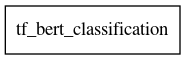

In [99]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [100]:
model.inputs

{'attention_mask': <tf.Tensor 'attention_mask_4:0' shape=(None, 512) dtype=int32>,
 'input_ids': <tf.Tensor 'input_ids_4:0' shape=(None, 512) dtype=int32>,
 'token_type_ids': <tf.Tensor 'token_type_ids_4:0' shape=(None, 512) dtype=int32>}

In [101]:
model.outputs

[<tf.Tensor 'tf_bert_classification_4/Identity:0' shape=(None, 2) dtype=float32>]

In [102]:
model.layers

In [103]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_189 [] []
classifier [] []


### Validation of the model

#### Making prediction

In [104]:
# get probablility for each classes
if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_pred = tf.nn.softmax(model.predict(valid_dataset))
elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        y_pred = tf.squeeze(tf.nn.softmax(model.predict(valid_dataset)))

standard model: tf_bert_classification


In [146]:
tf.nn.softmax(model.predict(valid_dataset))

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[0.05090828, 0.94909173],
       [0.01116403, 0.988836  ],
       [0.58249706, 0.4175029 ],
       ...,
       [0.85302615, 0.14697383],
       [0.95922637, 0.04077363],
       [0.9674078 , 0.03259215]], dtype=float32)>

In [145]:
valid_dataset

<BatchDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

In [105]:
y_pred.shape

TensorShape([1000, 2])

In [106]:
# get predicted classes
y_pred_argmax = tf.math.argmax(y_pred, axis=1)        

In [107]:
(y_pred_argmax).shape

TensorShape([1000])

#### Extracting true classes

In [108]:
# extracting and flatten true classes
y_true_tf=valid_dataset.map(pp.label_extraction).flat_map(lambda x: valid_dataset.from_tensor_slices(x))

In [109]:
y_true=list(y_true_tf.as_numpy_iterator())

In [110]:
len(y_true), len(y_pred_argmax)

(1000, 1000)

#### Model performanes

In [111]:
print(classification_report(y_true, y_pred_argmax, target_names=info.features["label"].names))

              precision    recall  f1-score   support

         neg       0.92      0.89      0.91       503
         pos       0.90      0.92      0.91       497

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [112]:
mm.print_metrics(y_true, y_pred_argmax, mode='')

Model performance on the  dataset:
   Metric             
accuracy...........   0.9080
recall.............   0.9215
auc................   0.9081
precision (p=0.5)..   0.8963
precision (avg)....   0.8649
precision (micro)..   0.9080
precision (macro)..   0.9083
f1.................    0.9087
r2.................    0.6320


#### Confusion matrix

In [113]:
plt.rcParams['figure.figsize'] = [10, 7]

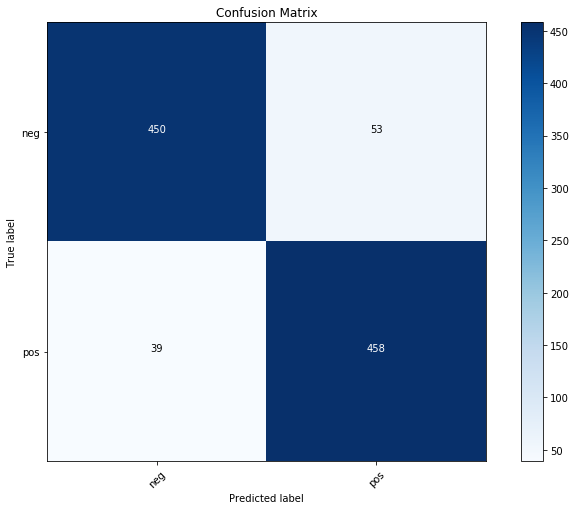

In [114]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names)

#### ROC curves

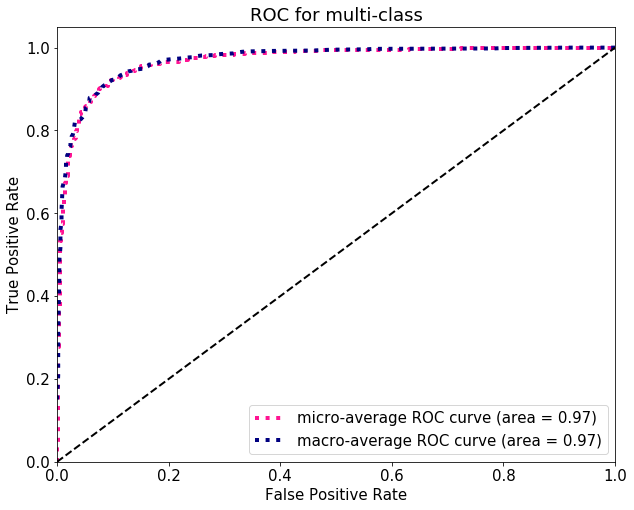

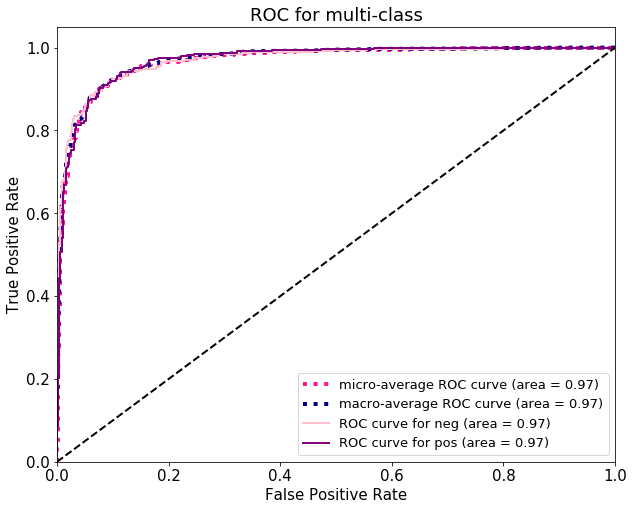

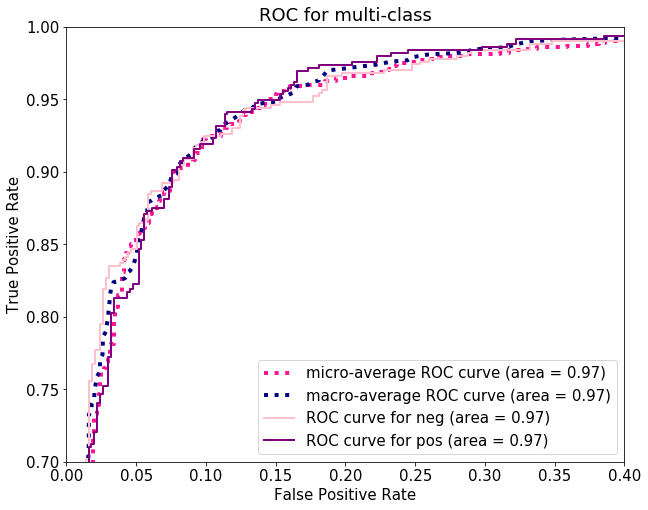

In [115]:
mm.roc_curves(to_categorical(y_true), y_pred.numpy(), info.features["label"].names)

#### Making new prediction

In [116]:
# getting a random example from the test data
for i in valid_data_np.shuffle(100).take(1):
    example = i['sentence']
    print('sentence: {}\nlabel:    {}'.format(i['sentence'].numpy().decode(), info.features["label"].names[i['label'].numpy()]))

sentence: This classic has so many great one liners and unintentionally hilarious scenes that I don't even know where to start. If you want advice on dating, its here. Just totally ignore the person you want, and then spout out classic lines like "Chicken's good...I like Chicken", and before you know it you will be having a one nighter in a basement (it's a NICE basement) with a woman who is 35 years younger than you. Bronson does it all in this film. He buys a car for no good reason just so he can murder two gang members...paying with "CASH"......chunnng.... He buys an ice cream, simply because "this is America, isn't it", and ends up wasting someone named "the giggler   he laughs when he runs" just because he stole his camera. By the way, this "giggler" is so fast that Bronson's regular pistol can't even catch up to him, he needs to order a special one just to get this elusive creep. He gets cleaned up just so he can eat a REALLY smelly meal (stuffed cabbage) in a rat trap with a cou

In [117]:
# conda install googletrans
from googletrans import Translator

# translate some example in some languages
# original entry:
# Role reversal remake of 1942's "The Major and the Minor" has Jerry Lewis stepping into the part originally played by Ginger Rogers, but unfortunately 
# this anemic outing is missing a lot more than just Ginger. Lewis attempts to pass for a child when boarding a train; he's successful, but the deception 
# leads to a string of comic and romantic confusions. Sidney Sheldon adapted the screenplay, tossing in musical moments for Dean Martin (playing yet 
# another in his stable of second bananas) and a jewel robbery subplot (which is dire). Diana Lynn, who played the wily teenager in the original film, 
# plays Lewis' love interest here. She's cute; Jerry isn't. *1 2 from ****
#text_en = ["Role reversal remake of 1942's 'The Major and the Minor' has Jerry Lewis stepping into the part originally played by Ginger Rogers, but unfortunately this anemic outing is missing a lot more than just Ginger. Lewis attempts to pass for a child when boarding a train; he's successful, but the deception leads to a string of comic and romantic confusions. Sidney Sheldon adapted the screenplay, tossing in musical moments for Dean Martin (playing yet another in his stable of second bananas) and a jewel robbery subplot (which is dire). Diana Lynn, who played the wily teenager in the original film, plays Lewis' love interest here. She's cute; Jerry isn't. *1 2 from ****"]
#text_de = ["Das Rollentausch-Remake von 'The Major and the Minor' aus dem Jahr 1942 lässt Jerry Lewis in die Rolle von Ginger Rogers eintreten, aber leider fehlt diesem anämischen Ausflug viel mehr als nur Ginger. Lewis versucht beim Einsteigen in einen Zug als Kind zu gelten. Er ist erfolgreich, aber die Täuschung führt zu einer Reihe von komischen und romantischen Verwirrungen. Sidney Sheldon adaptierte das Drehbuch und warf musikalische Momente für Dean Martin (der noch einen weiteren in seinem Stall mit zweiten Bananen spielt) und eine Nebenhandlung über Juwelenraub (was schrecklich ist) ein. Diana Lynn, die im Originalfilm den schlauen Teenager spielte, spielt hier Lewis' Liebesinteresse. Sie ist süß; Jerry aber nicht. * 1 2 von ****"]
#text_fr = ["Le remake d'inversion des rôles de 'The Major and the Minor' de 1942 a Jerry Lewis entrer dans le rôle initialement joué par Ginger Rogers, mais malheureusement cette sortie anémique manque beaucoup plus que juste Ginger. Lewis tente de passer pour un enfant à bord d'un train; il a réussi, mais la tromperie mène à une chaîne de confusions comiques et romantiques. Sidney Sheldon a adapté le scénario, jetant des moments musicaux pour Dean Martin (jouant encore un autre dans son écurie de secondes bananes) et une intrigue secondaire de vol de bijoux (ce qui est terrible). Diana Lynn, qui a joué l'adolescente astucieuse dans le film original, joue l'intérêt amoureux de Lewis ici. Elle est mignonne; Jerry ne l'est pas. * 1 2 de ****"]
translator = Translator()
text_en = example.numpy().decode()
#test = translator.translate("Hello, this is a test.", dest='fr')
#print(test.text)
#print(text_en)
text_fr = translator.translate(text_en, dest='fr').text
text_de = translator.translate(text_en, dest='de').text
print(text_fr, '\n', text_de)

Ce classique a tant de grandes scènes et une liners involontairement hilarantes que je ne sais même pas par où commencer. Si vous voulez des conseils sur la datation, son ici. Il suffit de ne pas tenir compte tout à fait la personne que vous voulez, et le bec puis des lignes classiques comme « le bon de poulet ... Je comme le poulet », et avant que vous le savez vous allez avoir une nuit blanche dans un sous-sol (il est un sous-sol de NICE) avec une femme qui est 35 ans plus jeune que vous. Bronson fait tout dans ce film. Il achète une voiture sans raison juste pour qu'il puisse assassiner deux membres de gangs ... de payer avec « CASH » ...... chunnng .... Il achète une crème glacée, tout simplement parce que «c'est l'Amérique, ISN » t il » et finit par quelqu'un débilitante nommé « le Giggler il rit quand il court » juste parce qu'il a volé sa caméra. Soit dit en passant, ce « Giggler » est si rapide que le pistolet régulier de Bronson ne peut même rattraper lui, il a besoin de comma

In [140]:
# conda install google-cloud-translate
from google.cloud import translate_v2 as translate
translate_client = translate.Client()

#result = translate_client.translate(
#    text_en, target_language='de')

#print(u'Text: {}'.format(result['input']))
#print(u'Translation: {}'.format(result['translatedText']))
#print(u'Detected source language: {}'.format(
#    result['detectedSourceLanguage']))

text_fr = translate_client.translate(text_en, target_language='fr')['translatedText']
text_de = translate_client.translate(text_en, target_language='de')['translatedText']

print(text_fr, '\n', text_de)

Ce classique a tellement de super doublures et de scènes involontairement hilarantes que je ne sais même pas par où commencer. Si vous voulez des conseils sur les rencontres, c&#39;est ici. Ignorez totalement la personne que vous voulez, puis lancez des lignes classiques comme &quot;Chicken&#39;s good ... I like Chicken&quot;, et avant de vous en rendre compte, vous aurez une nuit dans un sous-sol (c&#39;est un joli sous-sol) avec une femme qui a 35 ans de moins que toi. Bronson fait tout dans ce film. Il achète une voiture sans raison valable juste pour pouvoir assassiner deux membres de gangs ... en payant avec &quot;CASH&quot; ...... chunnng .... Il achète une glace, simplement parce que &quot;c&#39;est l&#39;Amérique, n&#39;est-ce pas&quot; t it &quot;, et finit par gaspiller quelqu&#39;un nommé&quot; le fou rire qu&#39;il rit quand il court &quot;juste parce qu&#39;il a volé son appareil photo. Soit dit en passant, ce &quot;glousseur&quot; est si rapide que le pistolet ordinaire d

In [175]:
def made_prediction(text, max_length):
    print('example of input:\n\n{}\n \nlength:{}\n'.format(text[0], len(text)))
    #print(‘text:{} length:{}\n’.format(text, len(text)))
    # get probablility for each classes
    tokens=tokenizer.batch_encode_plus(text, return_tensors="tf", pad_to_max_length=True, max_length=max_length)
    digits=model.predict(tokens)
    if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_single_pred = tf.nn.softmax(digits)
    elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        temp=tf.nn.softmax(digits)
        y_single_pred = tf.squeeze(temp)
    return y_single_pred.numpy()

In [157]:
tokens=tokenizer.batch_encode_plus("This is a test.", return_tensors="tf",  pad_to_max_length=True, max_length=SEQUENCE_LENGTH)
digits = tf.nn.softmax(model.predict(tokens))
digits


<tf.Tensor: shape=(15, 2), dtype=float32, numpy=
array([[0.5642907 , 0.43570933],
       [0.5827053 , 0.4172947 ],
       [0.45373687, 0.54626316],
       [0.48502573, 0.51497424],
       [0.48259225, 0.5174077 ],
       [0.45373687, 0.54626316],
       [0.48502573, 0.51497424],
       [0.48259225, 0.5174077 ],
       [0.49669424, 0.5033058 ],
       [0.48259225, 0.5174077 ],
       [0.5642907 , 0.43570933],
       [0.4460985 , 0.55390143],
       [0.48502576, 0.51497424],
       [0.5642907 , 0.4357093 ],
       [0.48759958, 0.5124004 ]], dtype=float32)>

In [176]:
y_single_pred_en=made_prediction(text_en)
y_single_pred_de=made_prediction(text_de)
y_single_pred_fr=made_prediction(text_fr)

TypeError: made_prediction() missing 1 required positional argument: 'max_length'

In [151]:
y_single_pred_en

array([[0.5642907 , 0.43570933],
       [0.5827053 , 0.4172947 ],
       [0.45373687, 0.54626316],
       ...,
       [0.58410066, 0.4158993 ],
       [0.4460985 , 0.55390143],
       [0.43300384, 0.5669962 ]], dtype=float32)

In [152]:
y_single_pred_de

array([[0.58410066, 0.4158993 ],
       [0.45373687, 0.54626316],
       [0.4460985 , 0.55390143],
       ...,
       [0.5686786 , 0.43132132],
       [0.5642907 , 0.43570933],
       [0.513251  , 0.48674905]], dtype=float32)

In [153]:
y_single_pred_fr

array([[0.5537481 , 0.44625193],
       [0.4460985 , 0.55390143],
       [0.48259225, 0.5174077 ],
       ...,
       [0.5686786 , 0.43132132],
       [0.5642907 , 0.43570933],
       [0.513251  , 0.48674905]], dtype=float32)

In [154]:
info.features["label"].names[tf.math.argmax(y_single_pred_en).numpy()]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
info.features["label"].names[tf.math.argmax(y_single_pred_de).numpy()]

In [ ]:
info.features["label"].names[tf.math.argmax(y_single_pred_fr).numpy()]

### Model interpretation

In [158]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=info.features["label"].names)

In [159]:
exp_en = explainer.explain_instance(text_en[0], made_prediction, num_features=6)

example of input:

T
 
length:5000

standard model: tf_bert_classification


In [161]:
# will do 5'000 permutations/selections of the original sentence and made prediction
exp_de = explainer.explain_instance(text_de[0], made_prediction, num_features=6)

example of input:

D
 
length:5000

standard model: tf_bert_classification


In [ ]:
exp_fr = explainer.explain_instance(text_fr[0], made_prediction, num_features=6)

example of input:

C
 
length:5000



In [ ]:
exp_en.as_list()

In [ ]:
exp_de.as_list()

In [ ]:
exp_fr.as_list()

In [ ]:
plt.style.use('dark_background')
fig = exp_de.as_pyplot_figure()

In [ ]:
exp_de.show_in_notebook(text=True)

In [ ]:
exp_de.save_to_file('ex_de.html')

In [ ]:
from IPython.display import IFrame    
IFrame(src="ex_de.html", width=900, height=350)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex_de.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

In [ ]:
plt.style.use('dark_background')
fig = exp_en.as_pyplot_figure()

In [ ]:
exp_en.show_in_notebook(text=True)

In [ ]:
exp_en.save_to_file('ex_en.html')

In [ ]:
from IPython.display import IFrame    
IFrame(src="ex_en.html", width=900, height=350)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex_en.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

In [ ]:
plt.style.use('dark_background')
fig = exp_fr.as_pyplot_figure()

In [ ]:
exp_fr.show_in_notebook(text=True)

In [ ]:
exp_fr.save_to_file('ex_fr.html')

In [ ]:
from IPython.display import IFrame    
IFrame(src="ex_fr.html", width=900, height=350)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<iframe src=ex_fr.html width=900 style="background: #FFFFFF;" height=350></iframe>'))

### Online Predictions

In [ ]:
#client = Client()
#client.get_bucket('multilingual_text_classification')